### Convert captions to lists of token indices

In [1]:
%pylab inline
import os
import re
import tqdm
import json
import time

j_train = json.loads(open('/home/paperspace/data/ms_coco/captions_train2014.json').read())
j_val = json.loads(open('/home/paperspace/data/ms_coco/captions_val2014.json').read())
train = {d['caption']: d['image_id'] for d in j_train['annotations']}
val = {d['caption']: d['image_id'] for d in j_val['annotations']}

print('filtering non-alphabetic characters'); time.sleep(.1)
for d in (train, val):
    for k, v in tqdm.tqdm(d.items()):
        d.pop(k)
        f = re.sub('[^a-z \h]', '', k.lower())
        d[f] = v

print('splitting on spaces and hashing'); time.sleep(.1)
total = train.keys() + val.keys()
words = set()
for caption in tqdm.tqdm(total):
    for w in caption.split(' '):
        if len(w) > 0:
            words.add(w)
words = sorted(list(words))
words_to_inds = dict(zip(words, range(len(words))))
inds_to_words = dict(zip(range(len(words)), words))

print('converting captions to indices'); time.sleep(.1)
for d in (train, val):
    for k, v in tqdm.tqdm(d.items()):
        d.pop(k)
        split_caption = [w for w in k.split(' ') if len(w) > 0]
        indices = [words_to_inds[w] for w in split_caption]
        try:
            d[v].append(indices)
        except:
            d[v] = []
            d[v].append(indices)

Populating the interactive namespace from numpy and matplotlib
filtering non-alphabetic characters


  0%|          | 0/597442 [00:00<?, ?it/s]

splitting on spaces and hashing


100%|██████████| 597442/597442 [00:02<00:00, 289112.63it/s]


converting captions to indices


100%|██████████| 197755/197755 [00:01<00:00, 105369.35it/s]


### Find an appropriate maximum caption length

max length: 49
mean length: 10.485191868
median length: 10.0
standard deviation: 2.40983629941
percent of total captions with greater than 20 words: 0.61%


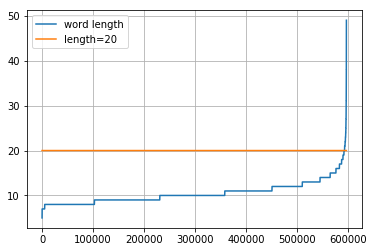

In [2]:
maxlen = 0
total = []
for d in (train, val):
    for k, v in d.items():
        for i, c in enumerate(v):
            size = len(c)
            total.append(size)
            if size > maxlen:
                maxlen = size
                max_id = k
                max_i = i
                max_d = d
                
total = array(total)
total.sort()
print('max length: '+str(maxlen)) 
print('mean length: '+str(total.mean()))
print('median length: '+str(median(total)))
print('standard deviation: '+str(total.std()))
print('percent of total captions with greater than 20 words: {:.2f}%'\
      .format(100 * (total > 20).sum() / float(total.size)))
plot(total, label='word length')
plot(arange(total.size), 20*ones(total.size), label='length=20')
legend(loc='best')
grid(which='both')

### Truncate captions and append EOF token

In [3]:
n = len(words)
words.append('EOF')
words_to_inds['EOF'] = n
inds_to_words[n] = 'EOF'

target_length = 20

for d in (train, val):
    for k, v in d.items():
        for i, c in enumerate(v):
            length = len(c)
            v[i] = c[:target_length-1]
            v[i].append(n)

### Visualize stats again

max length: 20
mean length: 11.4477455552
median length: 11.0
standard deviation: 2.19267018625
percent of total captions with greater than 20 words: 0.00%


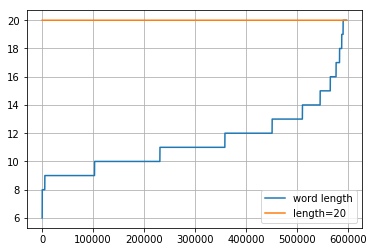

In [4]:
maxlen = 0
total = []
for d in (train, val):
    for k, v in d.items():
        for i, c in enumerate(v):
            size = len(c)
            total.append(size)
            if size > maxlen:
                maxlen = size
                max_id = k
                max_i = i
                max_d = d
                
total = array(total)
total.sort()
print('max length: '+str(maxlen)) 
print('mean length: '+str(total.mean()))
print('median length: '+str(median(total)))
print('standard deviation: '+str(total.std()))
print('percent of total captions with greater than 20 words: {:.2f}%'\
      .format(100 * (total > 20).sum() / float(total.size)))
plot(total, label='word length')
plot(arange(total.size), 20*ones(total.size), label='length=20')
legend(loc='best')
grid(which='both')

### Save

In [5]:
output_dir = '/home/paperspace/data/ms_coco/preproc'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
with open(os.path.join(output_dir, 'train_captions.json'), 'w') as outfile:
    json.dump(train, outfile)
with open(os.path.join(output_dir, 'val_captions.json'), 'w') as outfile:
    json.dump(val, outfile)
with open(os.path.join(output_dir, 'words_to_inds.json'), 'w') as outfile:
    json.dump(words_to_inds, outfile)
with open(os.path.join(output_dir, 'inds_to_words.json'), 'w') as outfile:
    json.dump(inds_to_words, outfile)